In [1]:
# ===================================================================
# Part 1: 设置与导入
# ===================================================================
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from PIL import Image
import pandas as pd
from tqdm import tqdm
import datetime
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# --- 核心配置区 ---
MODEL_CONFIG = {
    'model_name': 'ConvNeXt-XL', # <--- 目标模型: ConvNeXt-Large
    'batch_size': 16,      # ConvNeXt-L模型很大，建议从较小的batch_size开始，如16或24
    'learning_rate': 1e-4,
    'num_epochs': 30
}

# 基本设置
student_id = '22211360121'
subdir = ''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}, 正在配置模型: {MODEL_CONFIG['model_name']}")



使用的设备: cuda, 正在配置模型: ConvNeXt-XL


In [3]:
# ===================================================================
# Part 2: 训练 ConvNeXt-Large 模型
# ===================================================================

# --- 2.1 数据预处理 ---
print(f"\n--- 正在为 {MODEL_CONFIG['model_name']} 准备数据和变换 ---")
# 加载 ConvNeXt-Large 的官方预训练权重
weights = models.ConvNeXt_Large_Weights.DEFAULT # <--- 关键修改
model_official_transforms = weights.transforms()
print(f"{MODEL_CONFIG['model_name']} 官方推荐的预处理流程:")
print(model_official_transforms)

# 定义包含高级数据增强的训练集变换
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(model_official_transforms.crop_size[0], scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=model_official_transforms.mean, std=model_official_transforms.std),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
])
# 验证集和测试集使用官方标准变换
val_test_transform = model_official_transforms

# --- 2.2 数据加载 ---
full_train_dataset = torchvision.datasets.ImageFolder(root='new data/train')
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
train_subset.dataset.transform = train_transform
val_subset.dataset.transform = val_test_transform
train_loader = DataLoader(train_subset, batch_size=MODEL_CONFIG['batch_size'], shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=MODEL_CONFIG['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
class_names = full_train_dataset.classes
print(f"\n训练集大小: {len(train_subset)}, 验证集大小: {len(val_subset)}")


# --- 2.3 模型定义、优化器与调度器 ---
# 加载预训练的 ConvNeXt-Large 模型
model = models.convnext_large(weights=weights) # <--- 关键修改

# 替换分类头以适应我们的任务
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, len(class_names))

model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=MODEL_CONFIG['learning_rate'], weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# 初始化AMP梯度缩放器
scaler = torch.cuda.amp.GradScaler()


# --- 2.4 训练与验证循环 (集成AMP) ---
model_save_path = f"bird_classification_convnext_l_best.pth" # <--- 修改保存路径
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 7
train_loss_history, val_loss_history, val_acc_history = [], [], []



--- 正在为 ConvNeXt-XL 准备数据和变换 ---
ConvNeXt-XL 官方推荐的预处理流程:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

训练集大小: 3199, 验证集大小: 356


C:\Users\Krinv\AppData\Local\Temp\ipykernel_46772\1337773072.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [4]:
print(f"\n--- 开始为 {MODEL_CONFIG['model_name']} 进行实际训练 ---")

for epoch in range(MODEL_CONFIG['num_epochs']):
    model.train()
    total_train_loss = 0
    train_bar = tqdm(train_loader, desc=f'训练轮次 {epoch+1}/{MODEL_CONFIG["num_epochs"]}')
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()
        train_bar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{optimizer.param_groups[0]["lr"]:.1e}'})
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()
    total_val_loss, total_val_correct = 0, 0
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f'验证轮次 {epoch+1}/{MODEL_CONFIG["num_epochs"]}')
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == labels).sum().item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_val_correct / len(val_loader.dataset)
    val_loss_history.append(avg_val_loss)
    val_acc_history.append(val_accuracy)
    
    print(f'\n轮次 {epoch+1} | 训练损失: {avg_train_loss:.4f} | 验证损失: {avg_val_loss:.4f} | 验证准确率: {val_accuracy:.4f}')
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f'验证损失下降。保存最佳模型到 {model_save_path}')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= early_stop_patience:
        print(f'在 {epoch+1} 轮后触发早停机制。')
        break

print(f"\n--- {MODEL_CONFIG['model_name']} 训练完成！权重已保存至 {model_save_path} ---")


--- 开始为 ConvNeXt-XL 进行实际训练 ---


训练轮次 1/30:   0%|          | 0/200 [00:00<?, ?it/s]C:\Users\Krinv\AppData\Local\Temp\ipykernel_46772\3249587184.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
验证轮次 1/30:   0%|          | 0/23 [00:00<?, ?it/s]C:\Users\Krinv\AppData\Local\Temp\ipykernel_46772\3249587184.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
验证轮次 1/30: 100%|██████████| 23/23 [00:27<00:00,  1.20s/it]



轮次 1 | 训练损失: 3.6478 | 验证损失: 2.3394 | 验证准确率: 0.6348
验证损失下降。保存最佳模型到 bird_classification_convnext_l_best.pth


训练轮次 2/30:  22%|██▏       | 44/200 [02:17<08:07,  3.13s/it, loss=2.1865, lr=1.0e-04] 


KeyboardInterrupt: 

In [ ]:
# ===================================================================
# Part 3: 预测与可视化
# ===================================================================
print(f"\n--- 开始使用 {MODEL_CONFIG['model_name']} 最佳模型进行预测 ---")

# --- 3.1 加载模型 ---
# 创建一个与保存的模型结构相同的空模型
model = models.convnext_large(weights=None) # <--- 关键修改
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval()

# --- 3.2 预测 (带TTA) ---
transform = val_test_transform # 使用标准的验证/测试变换
test_folder = 'new data/testB'
test_images = [img for img in os.listdir(test_folder) if img.endswith('.jpg')]
predicts = []
idx = []

with torch.no_grad():
    for img_name in tqdm(test_images, desc=f'使用 {MODEL_CONFIG["model_name"]} 和 TTA 进行预测'):
        img_path = os.path.join(test_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        
        images_tta = [
            transform(image),
            transform(transforms.functional.hflip(image))
        ]
        batch_tta = torch.stack(images_tta).to(device)
        
        with torch.cuda.amp.autocast():
             outputs_tta = model(batch_tta)

        probs_tta = torch.softmax(outputs_tta, dim=1)
        avg_probs = torch.mean(probs_tta, dim=0)
        _, predicted = torch.max(avg_probs, 0)
        
        predicts.append(predicted.item())
        idx.append(img_name.replace('.jpg', ''))

# --- 3.3 保存结果 ---
submission = pd.DataFrame({'id': idx, 'label': predicts})
submission['id'] = submission['id'].astype(int)
submission = submission.sort_values(by='id')
submission_filename = f"{student_id}_submission_convnext_l_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
submission.to_csv(submission_filename, index=False)
print(f"预测完成，结果已保存到 {submission_filename}！")



--- 开始使用 ConvNeXt-L 最佳模型进行预测 ---


使用 ConvNeXt-L 和 TTA 进行预测:   0%|          | 0/1172 [00:00<?, ?it/s]C:\Users\Krinv\AppData\Local\Temp\ipykernel_36732\788394090.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
使用 ConvNeXt-L 和 TTA 进行预测: 100%|██████████| 1172/1172 [00:32<00:00, 36.00it/s]

预测完成，结果已保存到 22211360121_submission_convnext_l_20250612_011138.csv！



--- 开始生成可视化图表 ---


c:\Softwares\Anaconda\envs\Deep\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Softwares\Anaconda\envs\Deep\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Softwares\Anaconda\envs\Deep\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Softwares\Anaconda\envs\Deep\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Softwares\Anaconda\envs\Deep\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s)

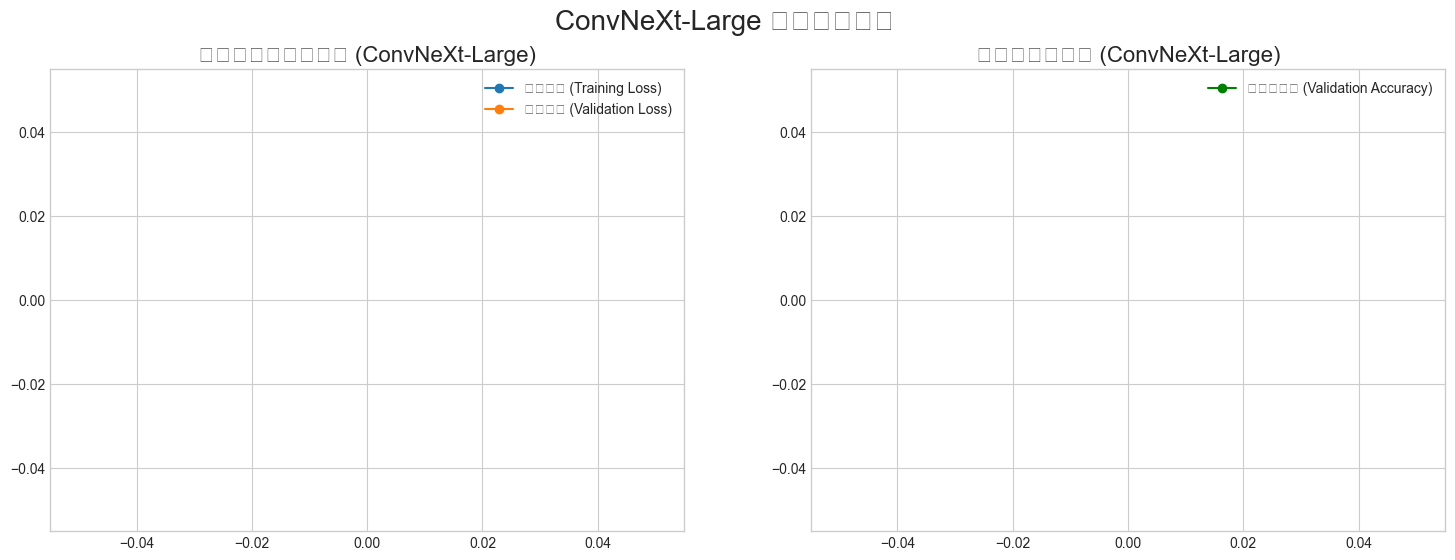

In [ ]:
# --- 3.4 可视化 ---
print("\n--- 开始生成可视化图表 ---")
num_actual_epochs = len(train_loss_history)
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(range(1, num_actual_epochs + 1), train_loss_history, 'o-', label='训练损失 (Training Loss)')
ax1.plot(range(1, num_actual_epochs + 1), val_loss_history, 'o-', label='验证损失 (Validation Loss)')
ax1.set_title('训练与验证损失曲线 (ConvNeXt-Large)', fontsize=16)
ax1.legend()

ax2.plot(range(1, num_actual_epochs + 1), val_acc_history, 'o-', label='验证准确率 (Validation Accuracy)', color='g')
ax2.set_title('验证准确率曲线 (ConvNeXt-Large)', fontsize=16)
ax2.legend()

plt.suptitle('ConvNeXt-Large 训练过程监控', fontsize=20)
plt.show()

---